✅ All imports successful!
Loaded 48446 valid words from corpus
Loaded 1933 valid words from test set

✅ Data loaded: 48446 corpus, 1933 test

🚀 TRAINING HANGMAN SYSTEM...

=== Training Smart HMM ===
✅ Trained on 13 word lengths
✅ HMM saved to smart_hmm.pkl

=== Training for 20000 episodes ===


Training:  10%|█         | 2007/20000 [00:32<05:09, 58.06it/s]


Episodes 1-2000:
  Success Rate: 59.9%
  Avg Reward: 3.0
  Epsilon: 0.110


Training:  20%|██        | 4009/20000 [01:07<04:34, 58.33it/s]


Episodes 2001-4000:
  Success Rate: 68.5%
  Avg Reward: 13.8
  Epsilon: 0.050


Training:  30%|███       | 6005/20000 [02:04<07:59, 29.20it/s]


Episodes 4001-6000:
  Success Rate: 79.5%
  Avg Reward: 38.0
  Epsilon: 0.050


Training:  40%|████      | 8004/20000 [03:22<06:58, 28.66it/s]


Episodes 6001-8000:
  Success Rate: 87.2%
  Avg Reward: 57.9
  Epsilon: 0.050


Training:  50%|█████     | 10004/20000 [04:39<05:44, 29.00it/s]


Episodes 8001-10000:
  Success Rate: 87.4%
  Avg Reward: 57.4
  Epsilon: 0.050


Training:  60%|██████    | 12005/20000 [05:56<04:17, 31.03it/s]


Episodes 10001-12000:
  Success Rate: 87.5%
  Avg Reward: 57.3
  Epsilon: 0.050


Training:  70%|███████   | 14002/20000 [07:16<03:36, 27.76it/s]


Episodes 12001-14000:
  Success Rate: 96.2%
  Avg Reward: 94.7
  Epsilon: 0.050


Training:  80%|████████  | 16003/20000 [08:36<02:17, 29.08it/s]


Episodes 14001-16000:
  Success Rate: 95.9%
  Avg Reward: 94.6
  Epsilon: 0.050


Training:  90%|█████████ | 18006/20000 [09:58<01:11, 28.07it/s]


Episodes 16001-18000:
  Success Rate: 96.0%
  Avg Reward: 91.6
  Epsilon: 0.050


Training: 100%|██████████| 20000/20000 [11:18<00:00, 29.49it/s]



Episodes 18001-20000:
  Success Rate: 96.5%
  Avg Reward: 95.3
  Epsilon: 0.050
✅ Agent saved to hybrid_agent.pkl
✅ Training complete!

📈 PLOTTING TRAINING RESULTS...


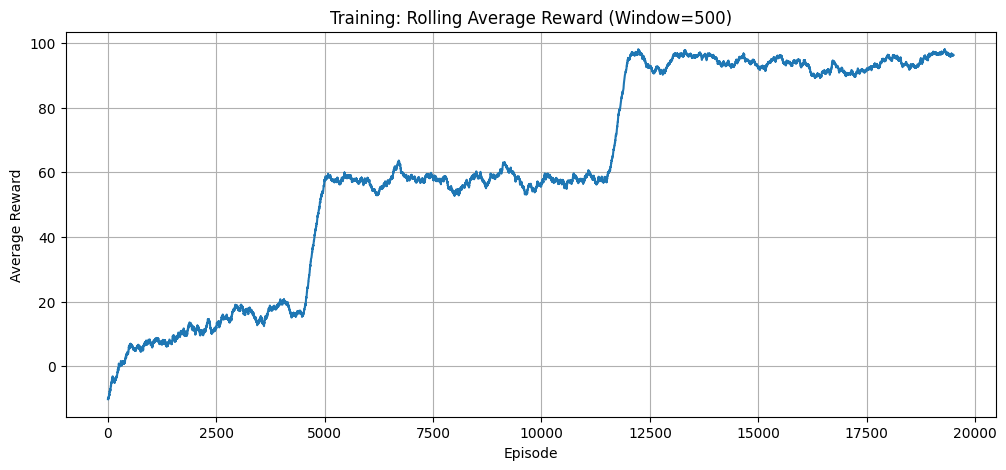

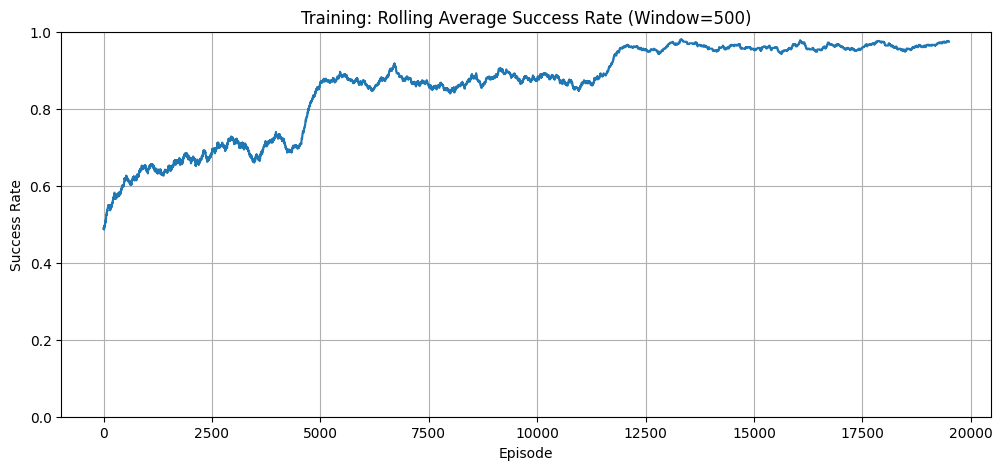

✅ Plots generated.


In [4]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm
import random
import json
import re

print("✅ All imports successful!")

# ============================================================================
# CELL 1: DATA LOADING
# ============================================================================

def load_corpus(filepath='corpus.txt'):
    """Load and preprocess the training corpus"""
    with open(filepath, 'r') as f:
        words = [line.strip().lower() for line in f if line.strip()]
    valid_words = [word for word in words if word.isalpha() and 3 <= len(word) <= 15]
    print(f"Loaded {len(valid_words)} valid words from corpus")
    return valid_words

def load_test_set(filepath='test.txt'):
    """Load the test set"""
    with open(filepath, 'r') as f:
        words = [line.strip().lower() for line in f if line.strip()]
    valid_words = [word for word in words if word.isalpha() and 3 <= len(word) <= 15]
    print(f"Loaded {len(valid_words)} valid words from test set")
    return valid_words

corpus_words = load_corpus('corpus.txt')
test_words = load_test_set('test.txt')

print(f"\n✅ Data loaded: {len(corpus_words)} corpus, {len(test_words)} test")

# ============================================================================
# CELL 2: SIMPLIFIED BUT POWERFUL HMM
# ============================================================================

class SmartHMM:
    """
    Simplified HMM focusing on what matters:
    1. Pattern matching with revealed letters
    2. Position-specific frequencies
    3. N-gram context
    """

    def __init__(self):
        self.word_dict = defaultdict(list)  # words by length
        self.position_freq = {}  # position-specific letter frequencies
        self.bigram_freq = defaultdict(Counter)
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

    def train(self, words):
        """Train on corpus - FAST and EFFECTIVE"""
        print("\n=== Training Smart HMM ===")

        # Group words by length
        for word in words:
            self.word_dict[len(word)].append(word)

        # Train position-specific frequencies for each length
        for length, word_list in self.word_dict.items():
            self.position_freq[length] = defaultdict(Counter)
            for word in word_list:
                for pos, letter in enumerate(word):
                    self.position_freq[length][pos][letter] += 1

                # Bigrams
                for i in range(len(word) - 1):
                    self.bigram_freq[word[i]][word[i+1]] += 1

        print(f"✅ Trained on {len(self.word_dict)} word lengths")

    def get_probabilities(self, masked_word, guessed_letters):
        """Get letter probabilities - THE KEY METHOD"""
        length = len(masked_word)
        remaining = self.alphabet - guessed_letters

        if not remaining:
            return {}

        # Strategy 1: PATTERN MATCHING (50% weight)
        pattern_scores = self._pattern_matching(masked_word, remaining, length)

        # Strategy 2: POSITION FREQUENCIES (30% weight)
        position_scores = self._position_frequencies(masked_word, remaining, length)

        # Strategy 3: BIGRAM CONTEXT (20% weight)
        bigram_scores = self._bigram_context(masked_word, remaining)

        # Combine scores
        final_scores = defaultdict(float)
        for letter in remaining:
            final_scores[letter] = (
                0.50 * pattern_scores.get(letter, 0.01) +
                0.30 * position_scores.get(letter, 0.01) +
                0.20 * bigram_scores.get(letter, 0.01)
            )

        # Normalize
        total = sum(final_scores.values())
        return {k: v/total for k, v in final_scores.items()}

    def _pattern_matching(self, masked_word, remaining, length):
        """Match against dictionary words - MOST POWERFUL"""
        scores = Counter()

        if length not in self.word_dict:
            return scores

        # Convert to regex
        pattern = masked_word.replace('_', '.')
        regex = re.compile(f"^{pattern}$")

        # Find matching words
        matches = [w for w in self.word_dict[length] if regex.match(w)]

        if matches:
            # Count letter frequencies in matches
            for word in matches:
                for letter in set(word):
                    if letter in remaining:
                        scores[letter] += 1

            # Normalize by number of matches
            for letter in scores:
                scores[letter] /= len(matches)

        return scores

    def _position_frequencies(self, masked_word, remaining, length):
        """Use position-specific frequencies"""
        scores = Counter()

        if length not in self.position_freq:
            return scores

        for pos, char in enumerate(masked_word):
            if char == '_':
                pos_freq = self.position_freq[length][pos]
                total = sum(pos_freq.values())
                if total > 0:
                    for letter in remaining:
                        scores[letter] += pos_freq.get(letter, 0) / total

        # Average across positions
        empty_count = masked_word.count('_')
        if empty_count > 0:
            for letter in scores:
                scores[letter] /= empty_count

        return scores

    def _bigram_context(self, masked_word, remaining):
        """Use bigram context from known letters"""
        scores = Counter()

        for i, char in enumerate(masked_word):
            if char != '_':
                # Check before
                if i > 0 and masked_word[i-1] == '_':
                    for letter in remaining:
                        scores[letter] += self.bigram_freq[letter].get(char, 0)

                # Check after
                if i < len(masked_word) - 1 and masked_word[i+1] == '_':
                    for letter in remaining:
                        scores[letter] += self.bigram_freq[char].get(letter, 0)

        # Normalize
        total = sum(scores.values())
        if total > 0:
            for letter in scores:
                scores[letter] /= total

        return scores

    def save(self, filepath='smart_hmm.pkl'):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"✅ HMM saved to {filepath}")

    @staticmethod
    def load(filepath='smart_hmm.pkl'):
        with open(filepath, 'rb') as f:
            return pickle.load(f)

# ============================================================================
# CELL 3: IMPROVED HANGMAN ENVIRONMENT
# ============================================================================

class HangmanEnv:
    """Simplified environment with better reward shaping"""

    def __init__(self, word_list, max_wrong=6):
        self.word_list = word_list
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        self.target_word = word if word else random.choice(self.word_list)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.done = False
        return self._get_state()

    def _get_state(self):
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses,
            'progress': self.masked_word.count('_') / len(self.masked_word)
        }

    def step(self, letter):
        letter = letter.lower()

        # Repeated guess
        if letter in self.guessed_letters:
            return self._get_state(), -10, self.done, {'repeated': True}

        self.guessed_letters.add(letter)

        # Correct guess
        if letter in self.target_word:
            new_masked = ''.join([
                letter if c == letter else self.masked_word[i]
                for i, c in enumerate(self.target_word)
            ])

            revealed = sum(1 for i in range(len(self.masked_word))
                          if new_masked[i] != '_' and self.masked_word[i] == '_')

            self.masked_word = new_masked

            # Reward: base + multiple occurrences bonus
            reward = 5 + revealed * 3

            # Win bonus
            if '_' not in self.masked_word:
                self.done = True
                reward += 30 + (self.max_wrong - self.wrong_guesses) * 5

        # Wrong guess
        else:
            self.wrong_guesses += 1
            reward = -5 - (self.max_wrong - self.wrong_guesses) * 2

            if self.wrong_guesses >= self.max_wrong:
                self.done = True
                reward -= 20

        return self._get_state(), reward, self.done, {}

    def get_stats(self):
        won = self.done and '_' not in self.masked_word
        return {
            'won': won,
            'wrong_guesses': self.wrong_guesses,
            'total_guesses': len(self.guessed_letters)
        }

# ============================================================================
# CELL 4: HYBRID Q-LEARNING AGENT
# ============================================================================

class HybridQLearning:
    """
    Hybrid approach: Use HMM heavily, learn Q-values for fine-tuning
    """

    def __init__(self, hmm, alpha=0.1, gamma=0.95, epsilon=0.3, epsilon_min=0.05):
        self.hmm = hmm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = 0.9995

        self.q_table = defaultdict(lambda: defaultdict(float))
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

    def _get_state_key(self, state):
        """Compact state representation"""
        masked = state['masked_word']
        lives = state['lives_left']
        progress = int((1 - state['progress']) * 10)  # 0-10 scale
        return f"{masked}|{lives}|{progress}"

    def choose_action(self, state, training=True):
        """Choose action - HEAVY HMM RELIANCE"""
        remaining = self.alphabet - state['guessed_letters']

        if not remaining:
            return None

        # Exploration (only during training)
        if training and random.random() < self.epsilon:
            return random.choice(list(remaining))

        # Get HMM probabilities
        hmm_probs = self.hmm.get_probabilities(
            state['masked_word'],
            state['guessed_letters']
        )

        # Get Q-values
        state_key = self._get_state_key(state)

        # Combine: 80% HMM, 20% Q-learning
        best_action = None
        best_score = -float('inf')

        for letter in remaining:
            hmm_score = hmm_probs.get(letter, 0.001) * 100
            q_value = self.q_table[state_key].get(letter, 0)

            # Weighted combination
            combined = 0.80 * hmm_score + 0.20 * q_value

            if combined > best_score:
                best_score = combined
                best_action = letter

        return best_action

    def update(self, state, action, reward, next_state, done):
        """Q-learning update"""
        state_key = self._get_state_key(state)

        if done:
            target = reward
        else:
            next_key = self._get_state_key(next_state)
            remaining = self.alphabet - next_state['guessed_letters']

            if remaining:
                max_next_q = max(self.q_table[next_key].get(a, 0) for a in remaining)
            else:
                max_next_q = 0

            target = reward + self.gamma * max_next_q

        current_q = self.q_table[state_key].get(action, 0)
        self.q_table[state_key][action] = current_q + self.alpha * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, filepath='hybrid_agent.pkl'):
        data = {
            'q_table': dict(self.q_table),
            'epsilon': self.epsilon
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"✅ Agent saved to {filepath}")

    def load(self, filepath='hybrid_agent.pkl'):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.q_table = defaultdict(lambda: defaultdict(float), data['q_table'])
        self.epsilon = data['epsilon']
        print(f"✅ Agent loaded from {filepath}")

# ============================================================================
# CELL 5: TRAINING
# ============================================================================

def train_agent(agent, env, episodes=20000, report_every=2000):
    """Train with proper curriculum"""
    print(f"\n=== Training for {episodes} episodes ===")

    rewards = []
    success_rates = []

    # Curriculum: easy -> medium -> hard
    all_words = env.word_list
    easy = [w for w in all_words if 3 <= len(w) <= 6]
    medium = [w for w in all_words if 5 <= len(w) <= 9]
    hard = [w for w in all_words if 7 <= len(w) <= 15]

    for ep in tqdm(range(episodes), desc="Training"):
        # Curriculum progression
        if ep < 5000:
            pool = easy if easy else all_words
        elif ep < 12000:
            pool = medium if medium else all_words
        else:
            pool = hard if hard else all_words

        state = env.reset(word=random.choice(pool))
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state, training=True)
            if action is None:
                break

            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

        agent.decay_epsilon()
        rewards.append(total_reward)
        success_rates.append(1 if env.get_stats()['won'] else 0)

        # Report
        if (ep + 1) % report_every == 0:
            recent_success = np.mean(success_rates[-report_every:]) * 100
            recent_reward = np.mean(rewards[-report_every:])
            print(f"\nEpisodes {ep+1-report_every+1}-{ep+1}:")
            print(f"  Success Rate: {recent_success:.1f}%")
            print(f"  Avg Reward: {recent_reward:.1f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")

    return rewards, success_rates

# ============================================================================
# CELL 6: TRAIN THE SYSTEM
# ============================================================================

print("\n🚀 TRAINING HANGMAN SYSTEM...")

# Train HMM
hmm = SmartHMM()
hmm.train(corpus_words)
hmm.save()

# Train RL agent
env = HangmanEnv(corpus_words, max_wrong=6)
agent = HybridQLearning(hmm, alpha=0.1, gamma=0.95, epsilon=0.3, epsilon_min=0.05)

rewards, success = train_agent(agent, env, episodes=20000, report_every=2000)
agent.save()

print("✅ Training complete!")

import matplotlib.pyplot as plt
import numpy as np

print("\n📈 PLOTTING TRAINING RESULTS...")

def rolling_average(data, window_size):
    """Calculates the rolling average of a 1D dataset."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Use a window size to smooth the 20,000 data points
WINDOW_SIZE = 500

# Ensure 'rewards' and 'success' variables exist from the training cell
if 'rewards' in locals() and 'success' in locals():
    # 1. Plot Average Reward
    plt.figure(figsize=(12, 5))
    plt.plot(rolling_average(rewards, WINDOW_SIZE))
    plt.title(f'Training: Rolling Average Reward (Window={WINDOW_SIZE})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

    # 2. Plot Success Rate
    plt.figure(figsize=(12, 5))
    plt.plot(rolling_average(success, WINDOW_SIZE))
    plt.title(f'Training: Rolling Average Success Rate (Window={WINDOW_SIZE})')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.ylim(0, 1) # Set y-axis from 0 (0%) to 1 (100%)
    plt.grid(True)
    plt.show()

    print("✅ Plots generated.")
else:
    print("⚠️ Could not find 'rewards' or 'success' variables.")
    print("Please make sure you have run 'CELL 6: TRAIN THE SYSTEM' first.")

In [5]:
# ============================================================================
# CELL 7: EVALUATION
# ============================================================================

def evaluate(agent, test_words, num_games=2000):
    """Comprehensive evaluation"""
    print(f"\n=== Evaluating on {min(num_games, len(test_words))} games ===")

    env = HangmanEnv(test_words, max_wrong=6)

    total = min(num_games, len(test_words))
    wins = 0
    total_wrong = 0
    total_repeated = 0

    results_by_length = defaultdict(lambda: {'won': 0, 'total': 0, 'wrong': []})

    test_sample = random.sample(test_words, total) if len(test_words) > total else test_words

    for word in tqdm(test_sample, desc="Evaluating"):
        state = env.reset(word=word)
        done = False

        while not done:
            action = agent.choose_action(state, training=False)
            if action is None:
                break

            next_state, reward, done, info = env.step(action)
            state = next_state

        stats = env.get_stats()

        if stats['won']:
            wins += 1
            results_by_length[len(word)]['won'] += 1

        results_by_length[len(word)]['total'] += 1
        results_by_length[len(word)]['wrong'].append(stats['wrong_guesses'])

        total_wrong += stats['wrong_guesses']
        # Note: Our env doesn't track repeated guesses separately in final stats

    success_rate = wins / total
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"Total Games:           {total}")
    print(f"Games Won:             {wins}")
    print(f"Success Rate:          {success_rate*100:.2f}%")
    print(f"Total Wrong Guesses:   {total_wrong}")
    print(f"Avg Wrong/Game:        {total_wrong/total:.2f}")
    print(f"\n🎯 FINAL SCORE:         {final_score:.2f}")
    print("="*70)

    print("\nPerformance by Word Length:")
    for length in sorted(results_by_length.keys()):
        data = results_by_length[length]
        rate = (data['won'] / data['total']) * 100
        avg_wrong = np.mean(data['wrong'])
        print(f"  Length {length:2d}: {data['won']:3d}/{data['total']:3d} ({rate:5.1f}%) - Avg Wrong: {avg_wrong:.2f}")

    return {
        'success_rate': success_rate,
        'total_wrong': total_wrong,
        'final_score': final_score,
        'wins': wins,
        'total': total
    }

# Run evaluation
print("\n📊 EVALUATING...")
results = evaluate(agent, test_words, num_games=2000)

# Save results
with open('final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ EVALUATION COMPLETE!")
print(f"\n🎯 FINAL SCORE: {results['final_score']:.2f}")
print(f"   Success Rate: {results['success_rate']*100:.1f}%")
print(f"   Total Wrong: {results['total_wrong']}")


📊 EVALUATING...

=== Evaluating on 1933 games ===


Evaluating: 100%|██████████| 1933/1933 [01:21<00:00, 23.79it/s]


EVALUATION RESULTS
Total Games:           1933
Games Won:             589
Success Rate:          30.47%
Total Wrong Guesses:   10200
Avg Wrong/Game:        5.28

🎯 FINAL SCORE:         -50390.58

Performance by Word Length:
  Length  3:   1/  9 ( 11.1%) - Avg Wrong: 5.78
  Length  4:   2/ 37 (  5.4%) - Avg Wrong: 5.89
  Length  5:   9/ 91 (  9.9%) - Avg Wrong: 5.82
  Length  6:  25/138 ( 18.1%) - Avg Wrong: 5.54
  Length  7:  36/205 ( 17.6%) - Avg Wrong: 5.62
  Length  8:  68/246 ( 27.6%) - Avg Wrong: 5.41
  Length  9:  71/274 ( 25.9%) - Avg Wrong: 5.39
  Length 10:  95/282 ( 33.7%) - Avg Wrong: 5.18
  Length 11:  87/226 ( 38.5%) - Avg Wrong: 5.11
  Length 12:  70/164 ( 42.7%) - Avg Wrong: 4.95
  Length 13:  58/128 ( 45.3%) - Avg Wrong: 4.89
  Length 14:  42/ 86 ( 48.8%) - Avg Wrong: 4.76
  Length 15:  25/ 47 ( 53.2%) - Avg Wrong: 4.53

✅ EVALUATION COMPLETE!

🎯 FINAL SCORE: -50390.58
   Success Rate: 30.5%
   Total Wrong: 10200
